### Process image data to make ready for training computer vision

**Structure**\
After cleaning up the folder structure, we have a number of folders under data/Indian_Food_Images and data/Food_Classification.  Each folder contains the name/label of a dish and contains images of that dish.

In [1]:
import pandas as pd
import os

from image_prep import get_img_df, train_val_test_split

##### Step 1: Associate image paths with label name in a dataframe.

In [6]:
ifi_path = "data/Indian_Food_Images/"
fc_path = "data/Food_Classification/"

df_ifi = get_img_df(ifi_path)
df_fc = get_img_df(fc_path)


In [7]:
# inspect
print(df_ifi.head(2))
print(df_fc.head(2))


       label                                              path
0  adhirasam  data/Indian_Food_Images/adhirasam/02d09e872d.jpg
1  adhirasam  data/Indian_Food_Images/adhirasam/02f2e49039.jpg
    label                                     path
0  burger  data/Food_Classification/burger/001.jpg
1  burger  data/Food_Classification/burger/002.jpg


Drop unwanted food items from Food Classification set (burger and pizza)

In [8]:
unwanted_food_list = ['burger','pizza']

df_fc = df_fc[~df_fc['label'].isin(unwanted_food_list)]
df_fc.label.unique()

array(['butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani',
       'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls',
       'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri',
       'pakode', 'pav_bhaji', 'samosa'], dtype=object)

In [9]:
# ensure paths are valid
def assert_df_valid_path(df):
    assert(os.path.isfile(df.iloc[0]['path']))

assert_df_valid_path(df_ifi)
assert_df_valid_path(df_fc)

##### Step 2: Test/Train Split

In [10]:
# first note how many of each class we have
df_ifi.value_counts('label')

label
adhirasam               50
aloo_gobi               50
naan                    50
mysore_pak              50
modak                   50
                        ..
daal_puri               50
daal_baati_churma       50
chikki                  50
chicken_tikka_masala    50
unni_appam              50
Name: count, Length: 80, dtype: int64

In [11]:
df_fc.value_counts('label')

label
chapati          413
kadai_paneer     412
chole_bhature    411
chai             381
fried_rice       355
pav_bhaji        353
butter_naan      329
dal_makhani      321
momos            319
masala_dosa      311
idli             310
jalebi           297
kaathi_rolls     293
dhokla           289
pakode           278
samosa           262
kulfi            237
paani_puri       130
Name: count, dtype: int64

Neither set has a lot of data to work with.  We might need to play with the percentages but we probably don't want less than 10 images in each of the test and validation sets.  For the Indian_Food_Images set, this would mean a 60/20/20 split.  We can use these proportions for both image sets.

In [12]:
train_ifi, test_ifi, validate_ifi = train_val_test_split(df_ifi, test_size=0.2, val_size=0.2)
train_fc, test_fc, validate_fc = train_val_test_split(df_fc, test_size=0.2, val_size=0.2)


In [13]:
train_fc.value_counts('label')

label
chapati          248
kadai_paneer     247
chole_bhature    246
chai             229
fried_rice       213
pav_bhaji        212
butter_naan      197
dal_makhani      193
momos            191
masala_dosa      187
idli             186
jalebi           178
kaathi_rolls     176
dhokla           173
pakode           167
samosa           157
kulfi            142
paani_puri        78
Name: count, dtype: int64

In [17]:
test_fc.value_counts('label')

label
chapati          82
chole_bhature    82
kadai_paneer     82
chai             76
fried_rice       71
pav_bhaji        70
butter_naan      66
dal_makhani      64
momos            64
masala_dosa      62
idli             62
kaathi_rolls     59
jalebi           59
dhokla           58
pakode           56
samosa           53
kulfi            48
paani_puri       26
Name: count, dtype: int64

In [18]:
validate_fc.value_counts('label')

label
chapati          83
chole_bhature    83
kadai_paneer     83
chai             76
pav_bhaji        71
fried_rice       71
butter_naan      66
dal_makhani      64
momos            64
masala_dosa      62
idli             62
jalebi           60
kaathi_rolls     58
dhokla           58
pakode           55
samosa           52
kulfi            47
paani_puri       26
Name: count, dtype: int64

##### Step 3: Process images so they can be used in computer vision

In [12]:
# TBD


0.6

##### [Spike] Importing Images

In [20]:
#import keras
import tensorflow as tf

In [39]:
# Got inspiration for splitting into train, test and validation sets from here
# https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
import math

def get_ttv_datasets(image_dir, test_split=0.2, val_split=0.2, 
                     image_size=(256,256), seed_train_validation=1):
    validation_split = test_split + val_split
    
    # It's unclear to me if this will stratify based on class.  I hope it does but haven't 
    # figured out how to verify yet.
    train_ds, test_val_ds = tf.keras.utils.image_dataset_from_directory(
        directory = image_dir,
        image_size = image_size,
        validation_split = validation_split,
        subset = "both",
        seed = seed_train_validation,
        label_mode="categorical",
        batch_size=10, # since ifi only has 50 images per class, make very small batches
        shuffle = True)
        
    # Also from stackoverflow link above, determine sets based on valid batches
    # In our case, we're evenly splitting between test and val
    test_val_batches = tf.data.experimental.cardinality(test_val_ds)
    
    # Due to some silliness with floats and EagerTensors, we can't do math to determine correct divisor
    # since it can only be an int.  To get a fraction, we'd have to multiple the numerator by some int
    # and divide by some other int.  Uhg.  Just dividing by 2 and will manually adjust if test_split
    # and val_split eventually use different values
    take_size = test_val_batches // 2    
    test_ds = test_val_ds.take(take_size)
    val_ds = test_val_ds.skip(take_size)
    
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_ttv_datasets(ifi_path)


Found 4000 files belonging to 80 classes.
Using 2400 files for training.
Using 1600 files for validation.


In [32]:
classes = train_ds.class_names

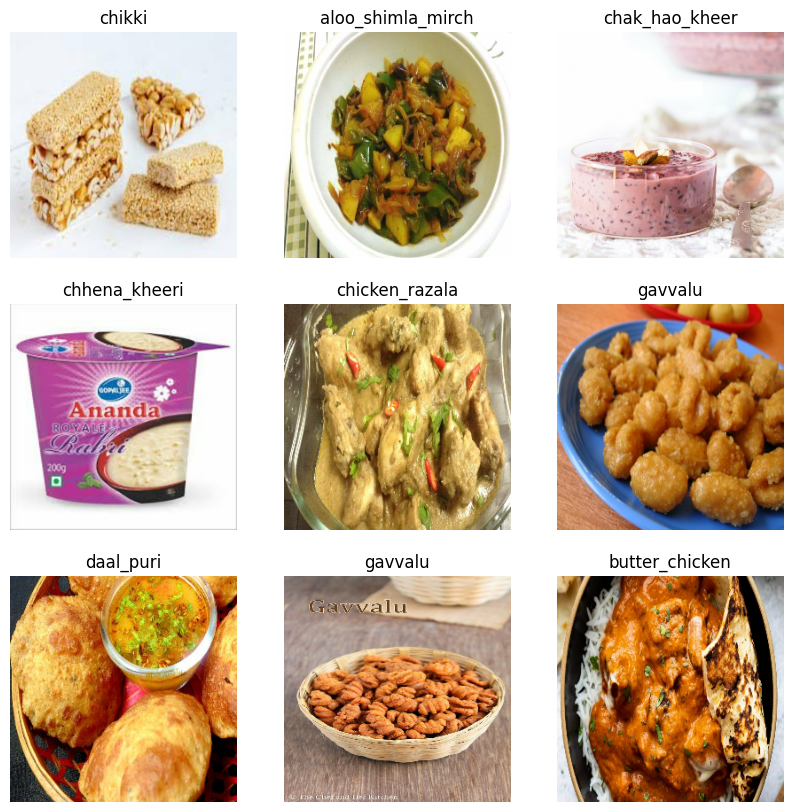

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# https://www.kaggle.com/code/mihailtimofeeff/tutorial-keras-image-classification
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")